# IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import joblib
import os

from imblearn.over_sampling import ADASYN

from src.ML_functions import get_param_dist_for_model, evaluate_model, plot_metrics_comparison, plot_roc_curves

from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [5]:
# Import Datasets

df_train = pd.read_csv('Data_for_Modelling/df_train.csv', sep=',')
df_train.drop('Unnamed: 0', axis=1, inplace=True)

df_test = pd.read_csv('Data_for_Modelling/df_test.csv', sep=',')
df_test.drop('Unnamed: 0', axis=1, inplace=True)

print(f"Train set shape:{df_train.shape}")
print(f"Test set shape:{df_test.shape}")

Train set shape:(377042, 11)
Test set shape:(127037, 10)


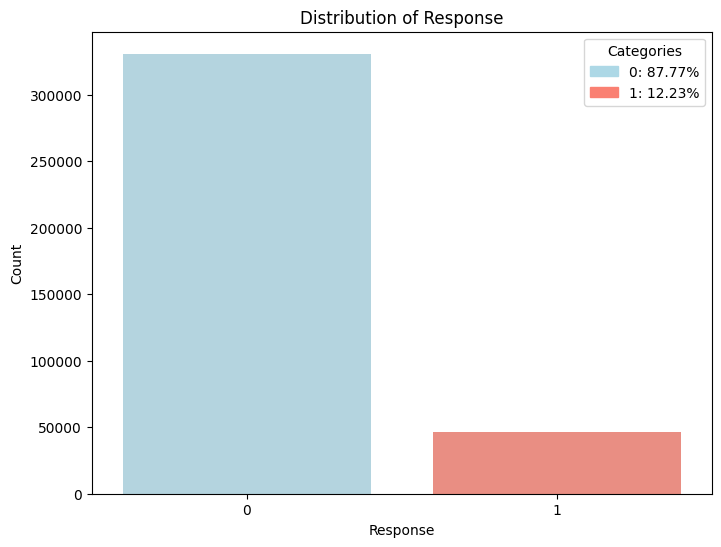

In [7]:
# How target column is distributed (IMBALANCED DATASET)

target_column = 'Response'

value_counts = df_train[target_column].value_counts()
percentages = (value_counts / value_counts.sum()) * 100

colors = ['lightblue', 'salmon']

plt.figure(figsize=(8, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette=colors, dodge=False, legend=False)
plt.xlabel(target_column)
plt.ylabel('Count')
plt.title(f'Distribution of {target_column}')
plt.xticks(rotation=0)

handles = [
    mpatches.Patch(color=colors[i], label=f'{index}: {percentages[i]:.2f}%')
    for i, index in enumerate(value_counts.index)
]
plt.legend(handles=handles, title='Categories', loc='upper right')

plt.show()

# TRAINING SET SPLIT AND MODELS DEFINITION

In [8]:
# Split df_train 

X = df_train.drop('Response', axis=1)
y = df_train['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f'Shape X Train: {X_train.shape}')
print(f'Shape X Test: {X_test.shape}')

Shape X Train: (339337, 10)
Shape X Test: (37705, 10)


In [9]:
# Models definition

models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

# MODELS EVALUATION WITH UNBALANCED DATASET

In [10]:
# RandomizedSearchCV 

models_dir = 'Models'
os.makedirs(models_dir, exist_ok=True)

best_models = {}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    
    print(f"Evaluating {name}...")

    search = RandomizedSearchCV(model, get_param_dist_for_model(name), cv=skf, scoring='f1', n_iter=10, n_jobs = -1, verbose=1)
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_

    print(f"Best model parameters for {name}:")
    print(search.best_estimator_)
    print(f"Mean F1 score for {name}: {search.best_score_:.4f}")

    joblib.dump(search.best_estimator_, f'{models_dir}/{name}.joblib')

Evaluating Random Forest...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/silvanoquarto/Desktop/PROJECTS/Health-Insurance-Prediction/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model parameters for Random Forest:
RandomForestClassifier()
Mean F1 score for Random Forest: 0.1795
Evaluating XGBoost...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best model parameters for XGBoost:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Mean F1 score for XGBo

In [11]:
# Load saved models

models_dir = 'Models'
best_models = {}

for model_file in os.listdir(models_dir):
    if model_file.endswith('.joblib'):
        model_name = model_file.split('.joblib')[0]
        best_models[model_name] = joblib.load(os.path.join(models_dir, model_file))

for name in best_models.keys():
    print(f"Loaded model: {name}")

Loaded model: XGBoost
Loaded model: Random Forest


In [12]:
# Models evaluation on training and test sets

results_train = {}
results_test = {}

for name, model in best_models.items():
    results_train[name] = evaluate_model(model, X_train, y_train)
    results_test[name] = evaluate_model(model, X_test, y_test)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

train_metrics_df = pd.DataFrame.from_dict({name: scores[:5] for name, scores in results_train.items()}, orient='index', columns=metrics)
test_metrics_df = pd.DataFrame.from_dict({name: scores[:5] for name, scores in results_test.items()}, orient='index', columns=metrics)

comparison_df = pd.concat([train_metrics_df, test_metrics_df], keys=['Train', 'Test'], axis=0)

comparison_df

Accuracy  Precision    Recall  F1 Score       AUC
Train XGBoost        0.878245   0.661191  0.007764  0.015348  0.862489
      Random Forest  0.999856   0.999735  0.999084  0.999409  1.000000
Test  XGBoost        0.877231   0.671642  0.009673  0.019072  0.860275
      Random Forest  0.865986   0.364252  0.115649  0.175559  0.832948

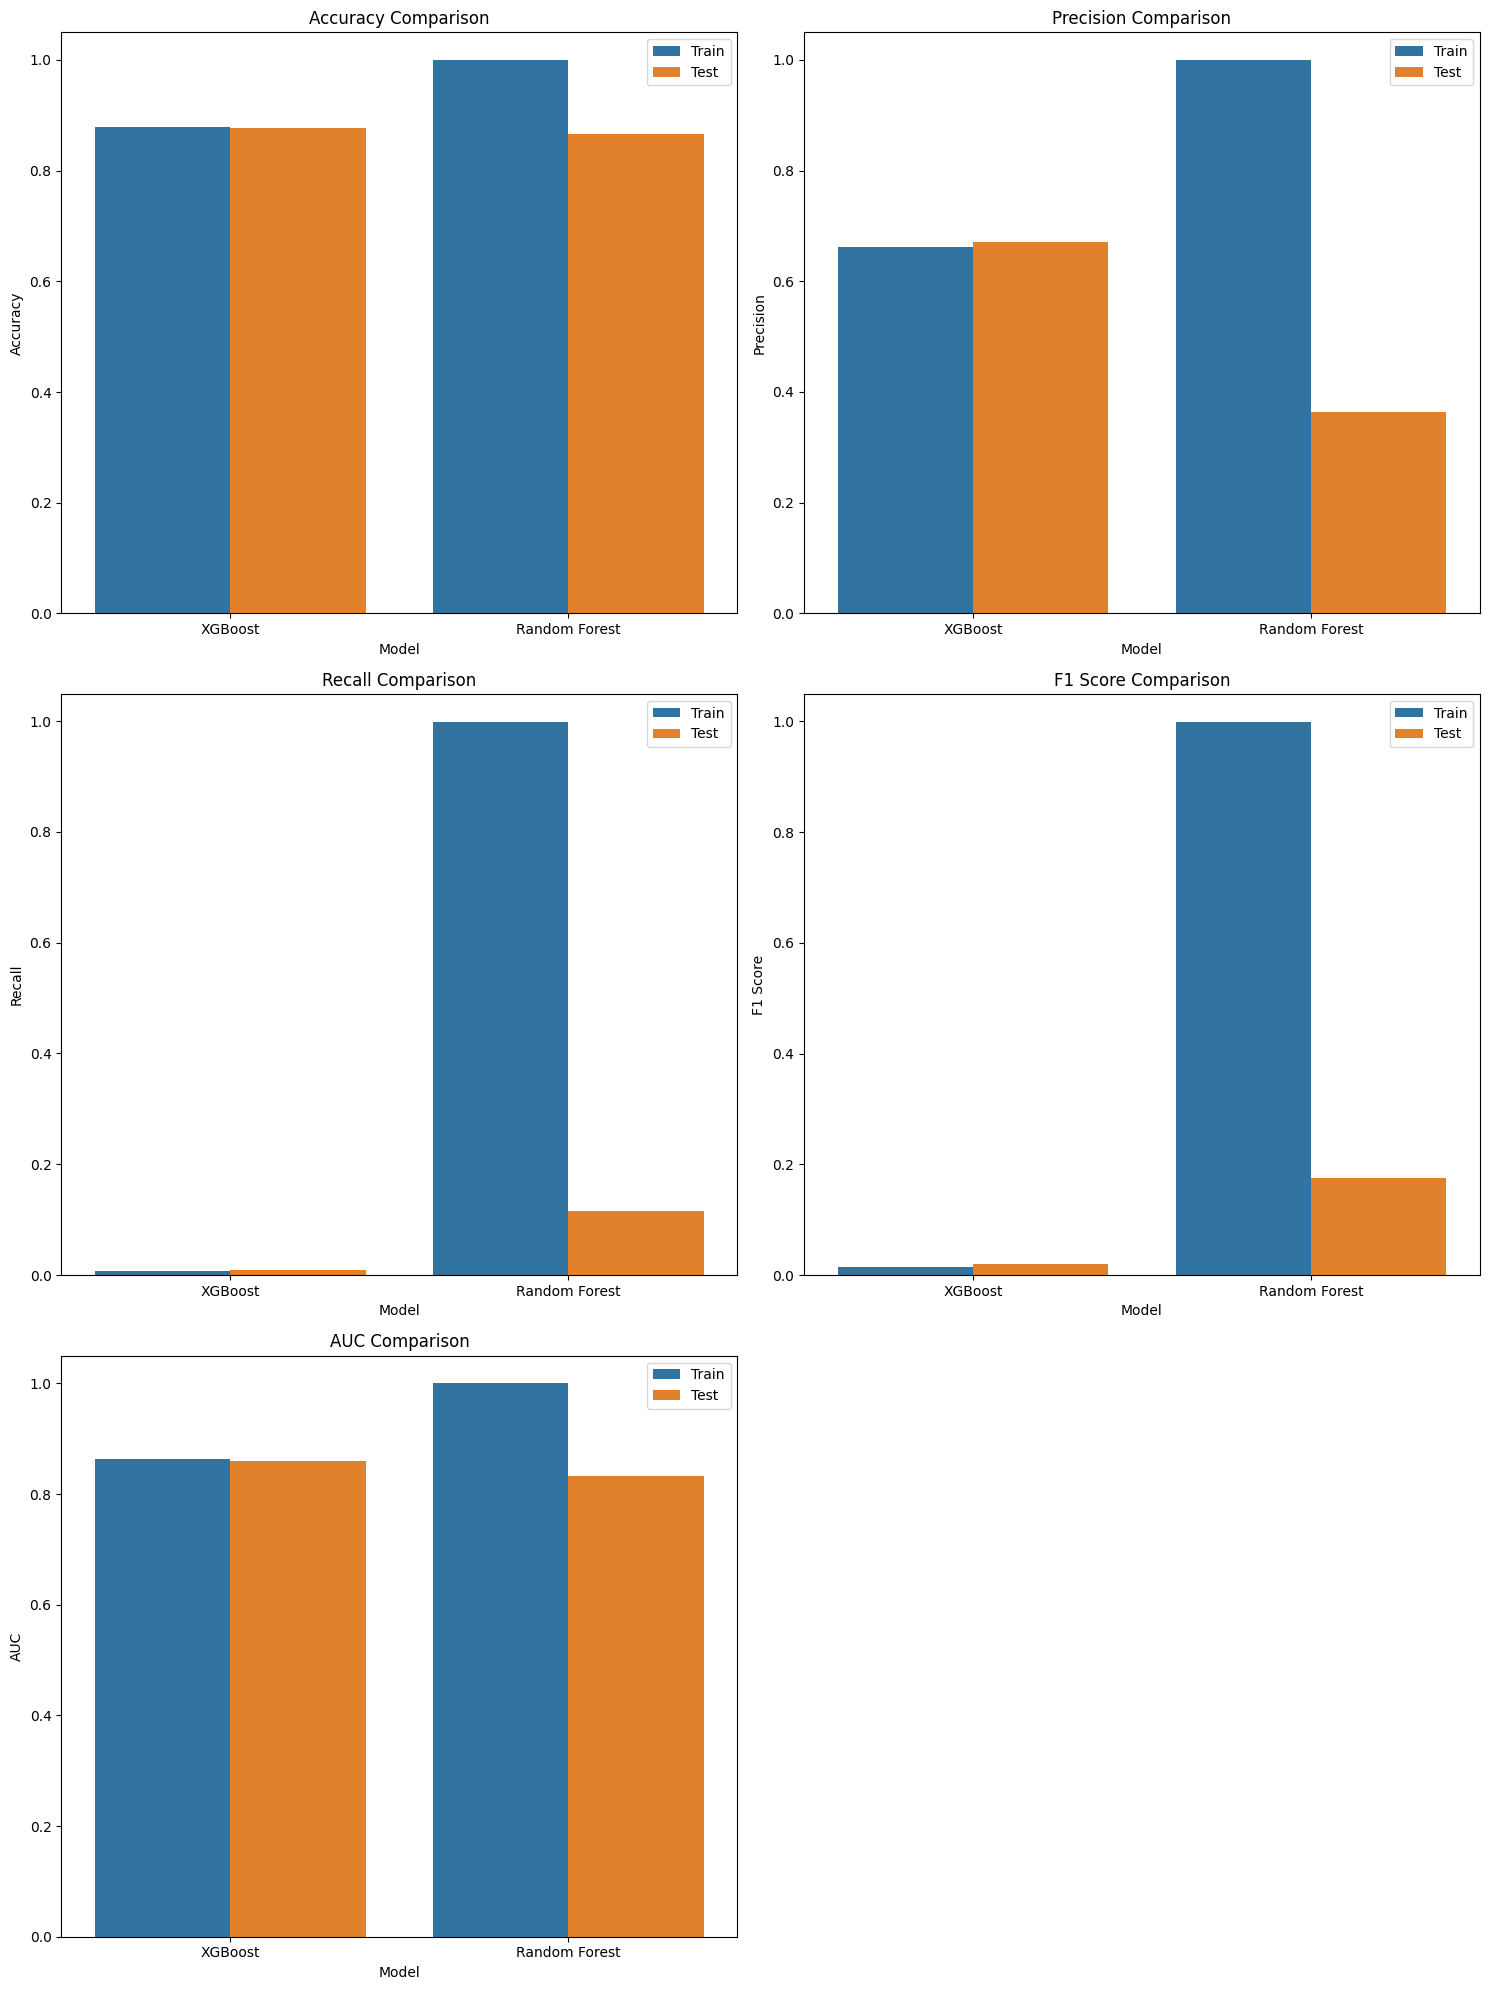

In [13]:
# Visualize comparison results

plot_metrics_comparison(comparison_df)

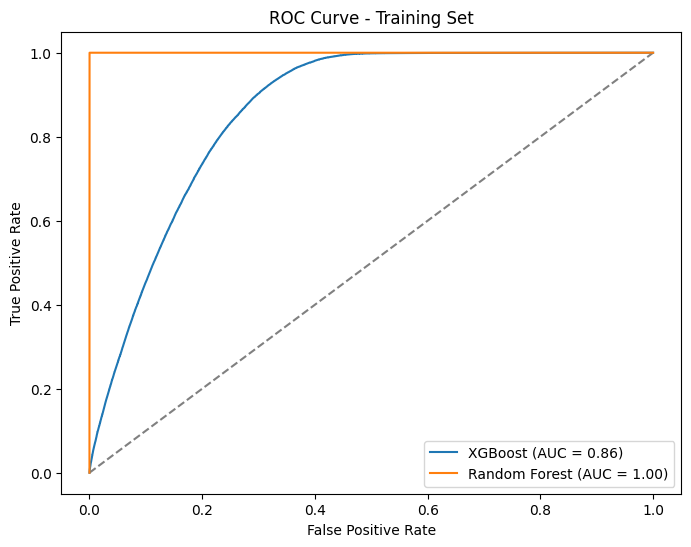

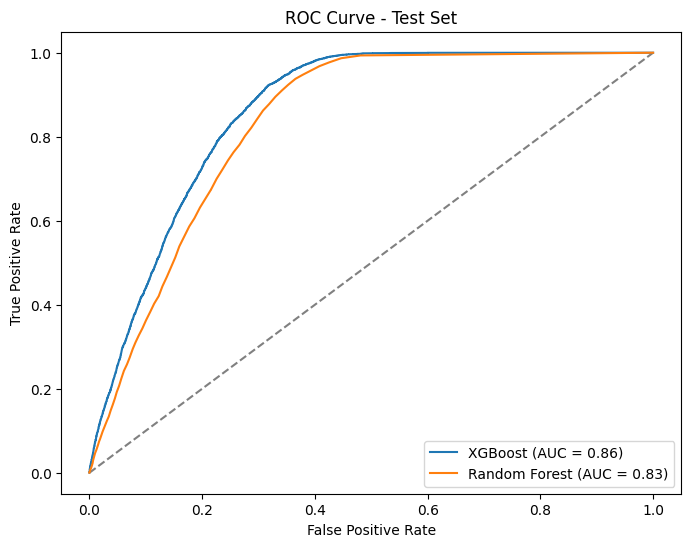

In [14]:
# ROC curve and AUC:

plot_roc_curves(results_train, set_type='train')
plot_roc_curves(results_test, set_type='test')

# MODELS EVALUATION USING ADASYN for RESAMPLING

In [15]:
# Oversampling with ADASYN

adasyn = ADASYN(random_state=42)

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print(f"X Train set shape:{X_train_resampled.shape}")
print(f"y Train set shape:{y_train_resampled.shape}")

X Train set shape:(605893, 10)
y Train set shape:(605893,)


In [16]:
# RandomizedSearchCV using resampled training set

models_ADASYN_dir = 'Models/Models_with_ADASYN'
os.makedirs(models_ADASYN_dir, exist_ok=True)

best_models_ADASYN = {}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    
    print(f"Evaluating {name}...")

    search = RandomizedSearchCV(model, get_param_dist_for_model(name), cv=skf, n_iter=10, verbose=1, n_jobs=-1)
    search.fit(X_train_resampled, y_train_resampled)
    best_models_ADASYN[name] = search.best_estimator_

    print(f"Best model parameters for {name}:")
    print(search.best_estimator_)
    print(f"Mean F1 score for {name}: {search.best_score_:.4f}")

    name_mod = name + '_with_ADASYN'

    joblib.dump(search.best_estimator_, f'{models_ADASYN_dir}/{name_mod}.joblib')

Evaluating Random Forest...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/silvanoquarto/Desktop/PROJECTS/Health-Insurance-Prediction/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model parameters for Random Forest:
RandomForestClassifier(max_features='log2', min_samples_split=5)
Mean F1 score for Random Forest: 0.8907
Evaluating XGBoost...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best model parameters for XGBoost:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_s

In [17]:
# Load saved models

models_ADASYN_dir = 'Models/Models_with_ADASYN'
best_models_ADASYN = {}

for model_file in os.listdir(models_ADASYN_dir):
    if model_file.endswith('.joblib'):
        model_name = model_file.split('.joblib')[0]
        best_models_ADASYN[model_name] = joblib.load(os.path.join(models_ADASYN_dir, model_file))

for name in best_models_ADASYN.keys():
    print(f"Loaded model: {name}")

Loaded model: XGBoost_with_ADASYN
Loaded model: Random Forest_with_ADASYN


In [18]:
# Models evaluation on training and test sets

results_ADASYN_train = {}
results_ADASYN_test = {}

for name, model in best_models_ADASYN.items():
    results_ADASYN_train[name] = evaluate_model(model, X_train_resampled, y_train_resampled)
    results_ADASYN_test[name] = evaluate_model(model, X_test, y_test)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

train_metrics_df_ADASYN = pd.DataFrame.from_dict({name: scores[:5] for name, scores in results_ADASYN_train.items()}, orient='index', columns=metrics)
test_metrics_df_ADASYN = pd.DataFrame.from_dict({name: scores[:5] for name, scores in results_ADASYN_test.items()}, orient='index', columns=metrics)

comparison_df_ADASYN = pd.concat([train_metrics_df_ADASYN, test_metrics_df_ADASYN], keys=['Train', 'Test'], axis=0)

comparison_df_ADASYN

Accuracy  Precision    Recall  F1 Score  \
Train XGBoost_with_ADASYN        0.861888   0.834770  0.908074  0.869880   
      Random Forest_with_ADASYN  0.992461   0.992227  0.992949  0.992588   
Test  XGBoost_with_ADASYN        0.789948   0.319647  0.622528  0.422404   
      Random Forest_with_ADASYN  0.814693   0.315881  0.430567  0.364414   

                                      AUC  
Train XGBoost_with_ADASYN        0.949225  
      Random Forest_with_ADASYN  0.999782  
Test  XGBoost_with_ADASYN        0.835450  
      Random Forest_with_ADASYN  0.827877

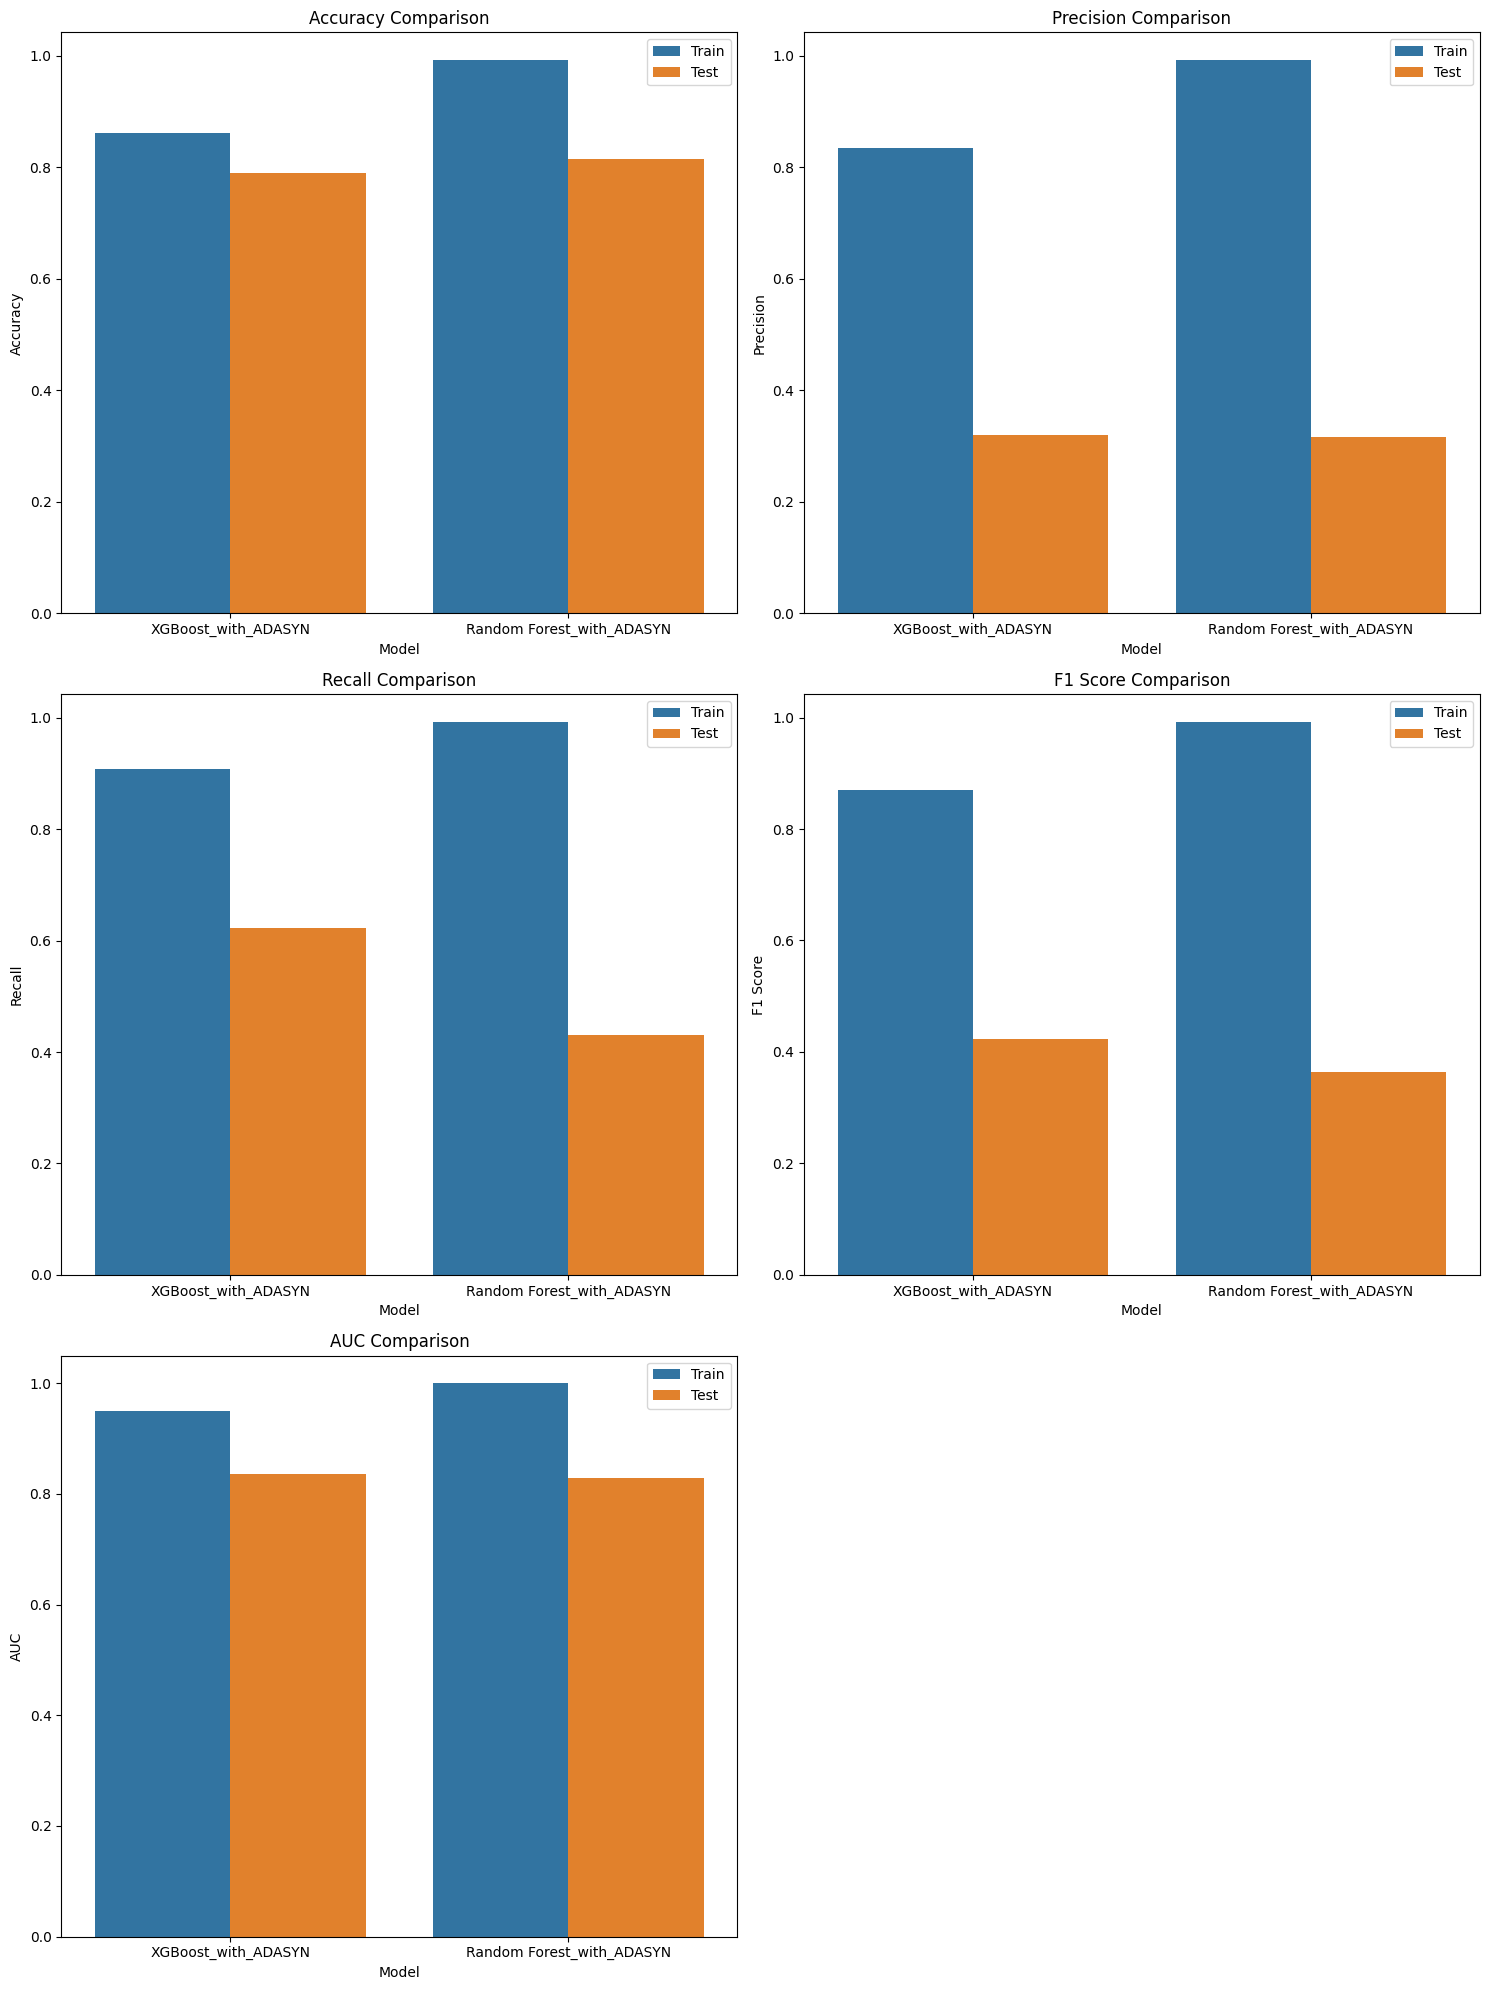

In [19]:
# Visualize comparison results

plot_metrics_comparison(comparison_df_ADASYN)

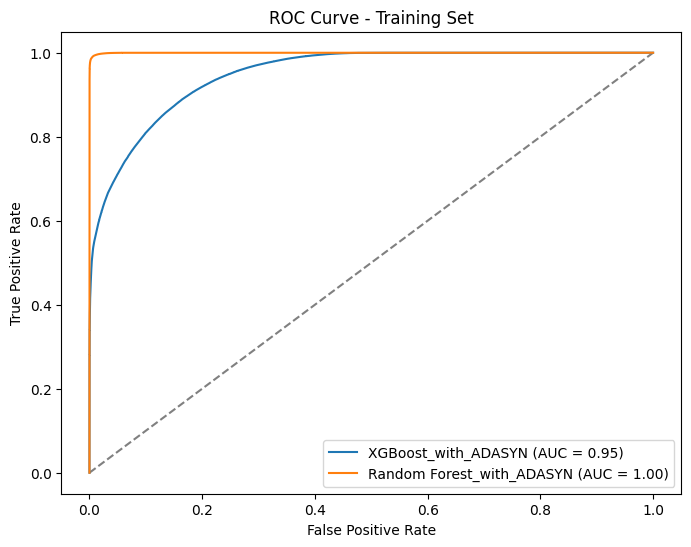

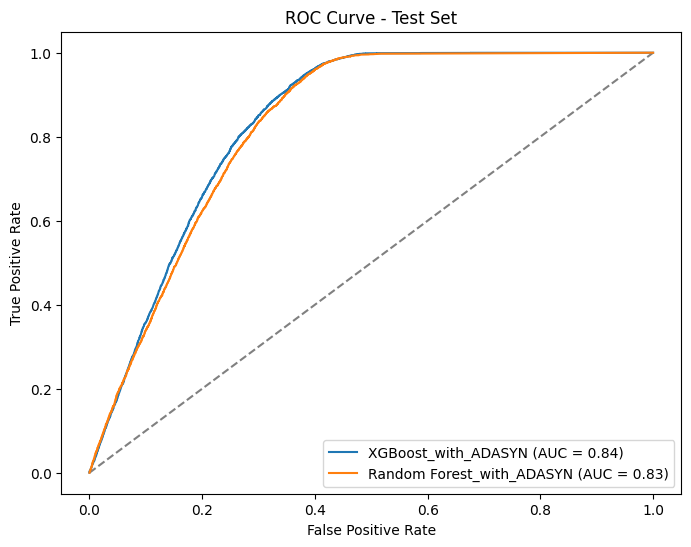

In [20]:
# ROC curve and AUC:

plot_roc_curves(results_ADASYN_train, set_type='train')
plot_roc_curves(results_ADASYN_test, set_type='test')

# DF TEST EVALUATION

In [21]:
# Evaluate Random Forest on df_test 

trained_model = best_models_ADASYN['XGBoost_with_ADASYN']

probabilities = trained_model.predict_proba(df_test)

mean_class_0_probs = probabilities[:, 0].mean()
mean_class_1_probs = probabilities[:, 1].mean()

probabilities_df = pd.DataFrame({
    'Class_0_Probabilities': probabilities[:, 0],
    'Class_1_Probabilities': probabilities[:, 1]
}, index=df_test.index)

probabilities_df['Predicted_Class'] = (probabilities_df['Class_1_Probabilities'] >= 0.5).astype(int)

probabilities_df

,Class_0_Probabilities,Class_1_Probabilities,Predicted_Class
0,0.999225,0.000775,0
1,0.466477,0.533523,1
2,0.417736,0.582264,1
3,0.987655,0.012345,0
4,0.999412,0.000588,0
...,...,...,...
127032,0.999350,0.000650,0
127033,0.369447,0.630553,1
127034,0.999547,0.000453,0
127035,0.999365,0.000635,0


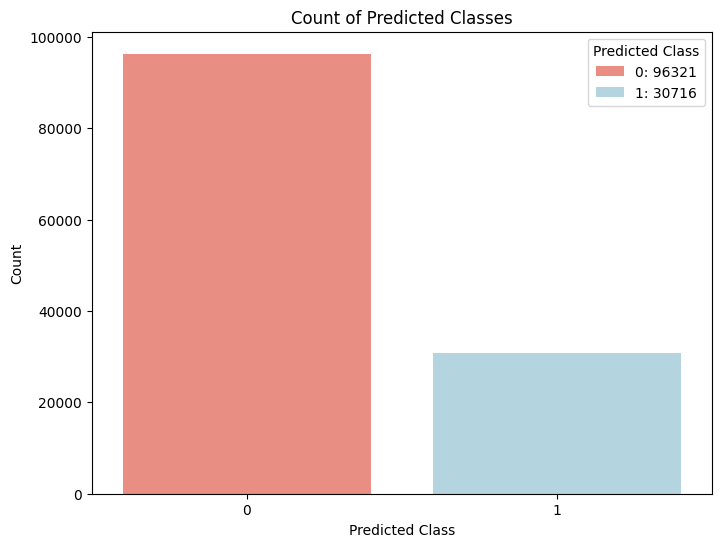

In [22]:
# Countplot of predicted classes

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Predicted_Class', data=probabilities_df, hue='Predicted_Class', palette=['salmon', 'lightblue'], legend=False)

class_counts = probabilities_df['Predicted_Class'].value_counts()

plt.legend(title='Predicted Class', labels=[f'{class_counts.index[i]}: {class_counts[i]}' for i in range(len(class_counts))])

plt.title('Count of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.show()